<a href="https://colab.research.google.com/github/kessingtonosazee/GCP_Project_1/blob/master/aml_2324_w7_autom_feat_sel_labwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated Feature Selection


* 6G7V0017 Advanced Machine Learning 23/24
* Luciano Gerber
* Semester 2 Week 7

## Why feature selection?

- Simplicity (fewer features, higher comprehensibility?)
- Prevent overfitting
- Prevent multicollinearity
- Uninformative features might hurt some models
- Train/predict performance

## Main Strategies

* https://scikit-learn.org/stable/modules/feature_selection.html

* unsupervised (e.g., removing features with low variance)

* supervised, univariate, correlation with target (e.g., select $k$ best) - metric is parameterisable

* multivariate
    - RFE (Recursive Feature Elimination)
    - From Model (e.g., feature importance based)
    - SFS (Sequential Feature Selection)


## Import Packages and Set Up Environment

In [1]:
!pip install --upgrade scikit-learn==1.4.0 -q
!pip install --upgrade category_encoders -q
!pip install -q shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 8.5 MB/s eta 0:00:00


In [2]:
import sklearn
sklearn.set_config(transform_output="pandas")

%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    { "figure.figsize": (6, 4) }, style='ticks', color_codes=True, font_scale=0.8
)

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.metrics import mean_absolute_error

import shap
shap.initjs()

##Load and Process to Data Frame

In [6]:
# loading data set
from sklearn.datasets import load_breast_cancer

In [8]:
X,y = load_breast_cancer(return_X_y = True, as_frame= True)

In [17]:
# Convert the y vector to a DataFrame and name it target
df_y = pd.DataFrame({'target': y})

# Concatenate along axis 1 (columns)
breast_cancer = pd.concat([X, df_y], axis=1)
breast_cancer.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## Case Study: Breast Cancer Dataset

### Making the Regression Dataset

The technicalities here are not the today's topic. The important message is that we ask `sklearn` to create a synthetic dataset with 200 samples, 10 features, 7 of which being informative, for a quantitative target (regression).

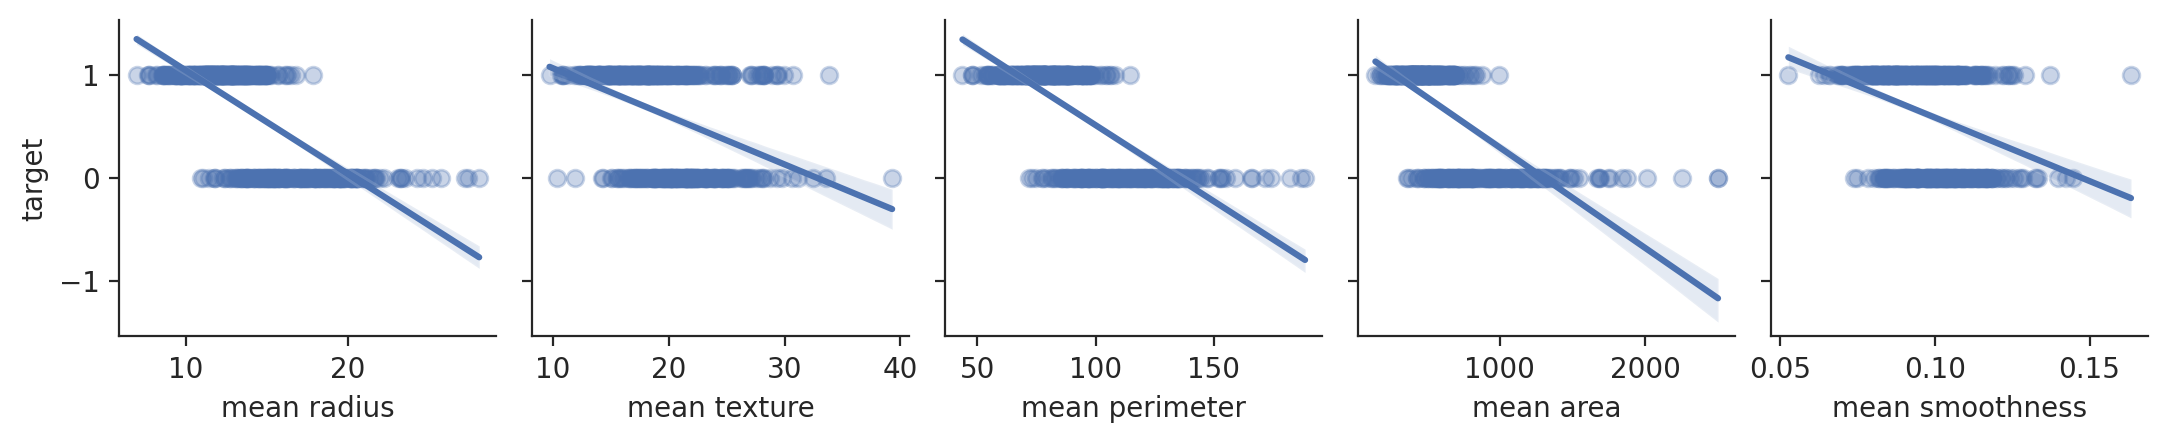

In [19]:
sns.pairplot(
    data=breast_cancer, x_vars=['mean radius','mean texture','mean perimeter','mean area','mean smoothness'], y_vars='target',
    kind='reg', plot_kws=dict(scatter_kws=(dict(alpha=0.3))),
    height=2.2
);

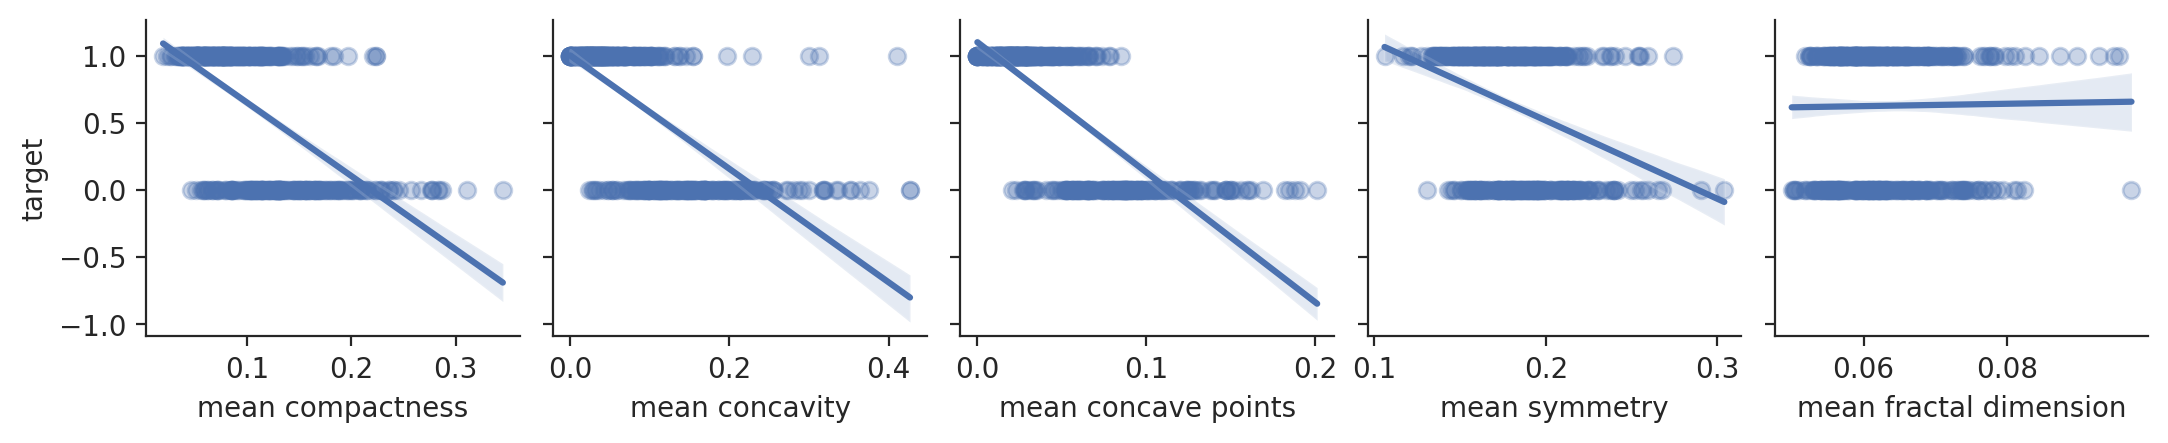

In [22]:
sns.pairplot(
    data=breast_cancer,
    x_vars=['mean compactness','mean concavity','mean concave points','mean symmetry','mean fractal dimension'],
    y_vars='target',
    height=2.2, kind='reg',
    plot_kws=dict(scatter_kws=(dict(alpha=0.3)))
 );

* **Which features would you exclude?**

### Automated Feature Selection (AFS): Univariate

* Supervised, univariate, **relationship with target**
    - We've done it before manually and with the support of EDA
    - Bear in mind that it is univariate... if a feature is useful only for interactions, it won't be picked up
    - Most common case is `SelectKBest` with `f_regression` or `f_classif`

In [24]:
from sklearn.feature_selection import SelectKBest, f_regression

In [25]:
selector = SelectKBest(f_regression, k=4).fit(X, y)
X_sel = selector.transform(X)

In [26]:
X_sel.head()

,mean concave points,worst radius,worst perimeter,worst concave points
0,0.14710,25.38,184.60,0.2654
1,0.07017,24.99,158.80,0.1860
2,0.12790,23.57,152.50,0.2430
3,0.10520,14.91,98.87,0.2575
4,0.10430,22.54,152.20,0.1625


In [27]:
selector.get_feature_names_out()

array(['mean concave points', 'worst radius', 'worst perimeter',
       'worst concave points'], dtype=object)

In [30]:
model1 = LinearRegression().fit(X_sel, y)
scores = cross_val_score(model1, X_sel, y)
scores.mean(), scores.std()

(0.651813202156024, 0.07243609670271872)

In [31]:
model2 = LinearRegression().fit(X, y)
scores = cross_val_score(model2, X, y)
scores.mean(), scores.std()

(0.704686173464433, 0.054732055682756985)

### Recursive Feature Elimination (RFE)

- mindset: start with all, build the model, look at **feature importance** (e.g., `coef_`), remove the least important, repeat.
- you will need to provide a $k$.

We will go straight to `RFECV`, where the best $k$ is obtained for you based on cross-validation scores.

In [32]:
from sklearn.feature_selection import RFECV

In [34]:
model3 = LinearRegression()
ref_selector = RFECV(model3, step=1, cv=5)

In [35]:
ref_selector.fit(X, y)

RFECV(cv=5, estimator=LinearRegression())

In [ ]:
X_sel = ref_selector.transform(X)
X_sel.head()

,x0,x1,x3,x4,x6,x7,x8
0,-0.056711,-0.040479,0.048749,-0.003496,-0.018376,-0.057141,-0.066291
1,0.015563,-0.132476,0.066564,0.044311,0.127621,0.102073,0.067242
2,0.023726,-0.001814,0.071639,0.013104,0.060048,0.040878,0.104568
3,-0.002274,0.097474,-0.030261,0.030729,0.004121,-0.013760,-0.041493
4,-0.003701,-0.031351,0.084394,0.060211,0.048933,-0.056874,-0.114203


In [ ]:
ref_selector.get_feature_names_out()

array(['x0', 'x1', 'x3', 'x4', 'x6', 'x7', 'x8'], dtype=object)

In [ ]:
n_scores = len(ref_selector.cv_results_["mean_test_score"])
n_scores

10

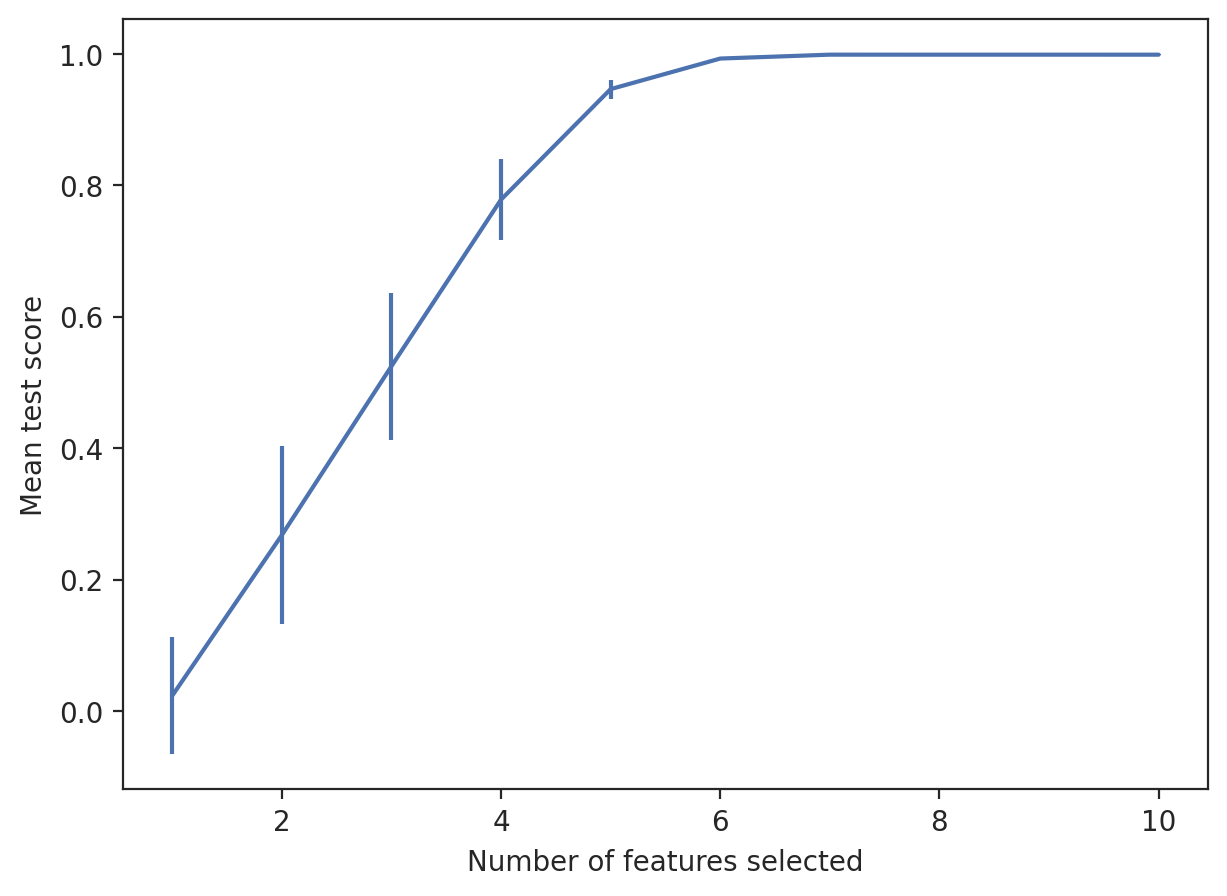

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ax.errorbar(
    range(1, n_scores+1),
    ref_selector.cv_results_["mean_test_score"],
    yerr=ref_selector.cv_results_["std_test_score"],
)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Mean test score");

### Sequential Feature Selection (SFS) (Forward/Backward)

- Greedy search
- Forward-SFS: "start with zero features and find the one feature that maximizes a cross-validated score when an estimator is trained on this single feature. Once that first feature is selected, we repeat the procedure by adding a new feature to the set of selected features. The procedure stops when the desired number of selected features is reached"
- difference from RFE: **model performance**

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

In [ ]:
sfs_forward = SequentialFeatureSelector(
    LinearRegression(), n_features_to_select='auto', direction="forward"
).fit(X, y)

from https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html:

    n_features_to_select“auto”, int or float, default=”auto”
    If "auto", the behaviour depends on the tol parameter:
    if tol is not None, then features are selected while the score change does not exceed tol.
    otherwise, half of the features are selected.
    If integer, the parameter is the absolute number of features to select. If float between 0 and 1, it is the fraction of features to select.

In [ ]:
sfs_forward.get_feature_names_out()

array(['x0', 'x1', 'x3', 'x8', 'x9'], dtype=object)

In [ ]:
X_sel = selector.transform(X)

In [ ]:
model = LinearRegression().fit(X_sel, y)
scores = cross_val_score(model, X_sel, y)
scores.mean(), scores.std()

(0.49968543254152253, 0.07497769377633372)

## Case Study: Bike Rides with Polynomial/Interaction Features, Pipeline

## The Bike Rides Dataset

In [ ]:
url = 'https://raw.githubusercontent.com/gerberl/6G7V0017-2324/main/datasets/bike.csv'
bike = pd.read_csv(url)
bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0
1,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,801,1
2,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,1349,2
3,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,1562,3
4,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,1600,4


In [ ]:
# we decided last week that we are happy keeping most existing features as predictors,
# but we'll take out *year*, as it doesn't seem to add much when we already have
# `days_since_2011`.

In [ ]:
y = bike['cnt']
X = bike.drop(['cnt', 'yr'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=0
)

In [ ]:
X_train.head(1)

,season,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,days_since_2011
97,SPRING,APR,NO HOLIDAY,FRI,WORKING DAY,MISTY,7.784151,83.625,15.208464,97


### Pre-Processing

We are dealing with numeric features in the default, simplistic way - median for missing values - and scaling/obtaining polynomial features for a linear regressor.

In [ ]:
numeric_features = X_train.select_dtypes(exclude='object').columns.tolist()
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler()),
        ("poly_int", PolynomialFeatures(degree=2, include_bias=False))
    ]
)
print(numeric_features)
numeric_transformer

['temp', 'hum', 'windspeed', 'days_since_2011']


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()),
                ('poly_int', PolynomialFeatures(include_bias=False))])

This is what the data flowing in the pipeline (for numeric features) would look like.

In [ ]:
numeric_transformer.fit_transform(X_train[numeric_features]).head()

,temp,hum,windspeed,days_since_2011,temp^2,temp hum,temp windspeed,temp days_since_2011,hum^2,hum windspeed,hum days_since_2011,windspeed^2,windspeed days_since_2011,days_since_2011^2
97,0.350240,0.804426,0.486058,0.132877,0.122668,0.281742,0.170237,0.046539,0.647101,0.390998,0.106889,0.236252,0.064586,0.017656
503,0.639257,0.355263,0.248737,0.689041,0.408650,0.227104,0.159007,0.440474,0.126212,0.088367,0.244791,0.061870,0.171390,0.474778
642,0.757395,0.641747,0.198020,0.879452,0.573647,0.486056,0.149979,0.666092,0.411839,0.127079,0.564386,0.039212,0.174149,0.773436
498,0.700435,0.431220,0.481123,0.682192,0.490610,0.302042,0.336996,0.477831,0.185951,0.207470,0.294175,0.231480,0.328218,0.465386
303,0.355515,0.613636,0.168555,0.415068,0.126391,0.218157,0.059924,0.147563,0.376549,0.103431,0.254701,0.028411,0.069962,0.172282


For categorical data, a straight-forward missing value imputation and one-hot encoding.

In [ ]:
categorical_features = X_train.select_dtypes(include='object').columns.tolist()
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='if_binary')),
        # ("te", TargetEncoder()),
        # ("scaler", MinMaxScaler()),
    ]
)

And this is what the data would look like...

In [ ]:
categorical_transformer.fit_transform(X_train[categorical_features]).head()
# categorical_transformer.fit_transform(X_train[categorical_features], y_train).head()

,season_FALL,season_SPRING,season_SUMMER,season_WINTER,mnth_APR,mnth_AUG,mnth_DEC,mnth_FEB,mnth_JAN,mnth_JUL,...,weekday_MON,weekday_SAT,weekday_SUN,weekday_THU,weekday_TUE,weekday_WED,workingday_WORKING DAY,weathersit_GOOD,weathersit_MISTY,weathersit_RAIN/SNOW/STORM
97,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
503,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
642,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
498,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
303,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

### Model Fitting: with and without FS

#### Without FS

In [ ]:
regr_noFS = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regr", LinearRegression())
    ]
)

In [ ]:
regr_noFS.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler()),
                                                                  ('poly_int',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['temp', 'hum', 'windspeed',
                                                   'days_since_2011']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['season', 'mnth', 'holiday',
                                                   'weekday', 'workingday',
                                                   'weathersit'])],
                                   verbose_feature_names_out=False)),
                ('regr', LinearRegression())])

In [ ]:
regr_noFS.score(X_test, y_test), regr_noFS.score(X_train, y_train)

(0.8798426725138498, 0.8840360618746198)

In [ ]:
mean_absolute_error(y_test, regr_noFS.predict(X_test)), mean_absolute_error(y_train, regr_noFS.predict(X_train))

(544.1119291618575, 471.03902132474127)

In [ ]:
eval_results = cross_validate(
    regr_noFS, X_train, y_train, cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)
(
    (-eval_results['test_score'].mean(), eval_results['test_score'].std(),
    -eval_results['train_score'].mean(), eval_results['train_score'].std())
)

(520.8249502428022, 12.695803128702785, 467.533062396459, 6.717796205453306)

In [ ]:
regr_noFS['preprocessor'].get_feature_names_out()

array(['temp', 'hum', 'windspeed', 'days_since_2011', 'temp^2',
       'temp hum', 'temp windspeed', 'temp days_since_2011', 'hum^2',
       'hum windspeed', 'hum days_since_2011', 'windspeed^2',
       'windspeed days_since_2011', 'days_since_2011^2', 'season_FALL',
       'season_SPRING', 'season_SUMMER', 'season_WINTER', 'mnth_APR',
       'mnth_AUG', 'mnth_DEC', 'mnth_FEB', 'mnth_JAN', 'mnth_JUL',
       'mnth_JUN', 'mnth_MAR', 'mnth_MAY', 'mnth_NOV', 'mnth_OCT',
       'mnth_SEP', 'holiday_NO HOLIDAY', 'weekday_FRI', 'weekday_MON',
       'weekday_SAT', 'weekday_SUN', 'weekday_THU', 'weekday_TUE',
       'weekday_WED', 'workingday_WORKING DAY', 'weathersit_GOOD',
       'weathersit_MISTY', 'weathersit_RAIN/SNOW/STORM'], dtype=object)

In [ ]:
len(regr_noFS['preprocessor'].get_feature_names_out())

42

#### With Best-k

In [ ]:
regr_bestk = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("featsel", SelectKBest(f_regression, k=10)),
        ("regr", LinearRegression())
    ]
)

In [ ]:
regr_bestk.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler()),
                                                                  ('poly_int',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['temp', 'hum', 'windspeed',
                                                   'days_since_2011']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['season', 'mnth', 'holiday',
                                                   'weekday', 'workingday',
                                                   'weathersit'])],
                                   verbose_feature_names_out=False)),
                ('featsel',
                 SelectKBest(score_func=<function f_regression at 0x795fdc335ab0>)),
                ('regr', LinearRegression())])

In [ ]:
regr_bestk['featsel'].get_feature_names_out()

array(['temp', 'days_since_2011', 'temp^2', 'temp hum',
       'temp days_since_2011', 'hum days_since_2011', 'days_since_2011^2',
       'season_SUMMER', 'season_WINTER', 'mnth_JAN'], dtype=object)

In [ ]:
len(regr_bestk['featsel'].get_feature_names_out())

10

In [ ]:
regr_bestk['featsel'].transform(
    regr_bestk['preprocessor'].transform(X_train)
).head()

,temp,days_since_2011,temp^2,temp hum,temp days_since_2011,hum days_since_2011,days_since_2011^2,season_SUMMER,season_WINTER,mnth_JAN
97,0.350240,0.132877,0.122668,0.281742,0.046539,0.106889,0.017656,0.0,0.0,0.0
503,0.639257,0.689041,0.408650,0.227104,0.440474,0.244791,0.474778,0.0,0.0,0.0
642,0.757395,0.879452,0.573647,0.486056,0.666092,0.564386,0.773436,0.0,0.0,0.0
498,0.700435,0.682192,0.490610,0.302042,0.477831,0.294175,0.465386,0.0,0.0,0.0
303,0.355515,0.415068,0.126391,0.218157,0.147563,0.254701,0.172282,0.0,0.0,0.0


In [ ]:
regr_bestk.score(X_test, y_test)

0.7914697231937506

In [ ]:
mean_absolute_error(y_test, regr_bestk.predict(X_test))

733.0230063684614

In [ ]:
eval_results = cross_validate(
    regr_bestk, X_train, y_train, cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)
(
    (-eval_results['test_score'].mean(), eval_results['test_score'].std(),
    -eval_results['train_score'].mean(), eval_results['train_score'].std())
)

(622.357509457298, 27.973005087360658, 613.2984060436656, 23.48973710944838)

#### With RFECV

In [ ]:
regr_rfe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("featsel", RFECV(model, step=1, cv=5)),
        ("regr", LinearRegression())
    ]
)

In [ ]:
regr_rfe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler()),
                                                                  ('poly_int',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['temp', 'hum', 'windspeed',
                                                   'days_since_2011']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['season', 'mnth', 'holiday',
                                                   'weekday', 'workingday',
                                                   'weathersit'])],
                                   verbose_feature_names_out=False)),
                ('featsel', RFECV(cv=5, estimator=LinearRegression())),
                ('regr', LinearRegression())])

In [ ]:
regr_rfe['featsel'].get_feature_names_out()

array(['temp', 'hum', 'windspeed', 'days_since_2011', 'temp^2',
       'temp hum', 'temp days_since_2011', 'hum^2', 'hum windspeed',
       'hum days_since_2011', 'windspeed^2', 'windspeed days_since_2011',
       'days_since_2011^2', 'season_FALL', 'season_SUMMER',
       'season_WINTER', 'mnth_DEC', 'mnth_FEB', 'mnth_JAN', 'mnth_JUN',
       'mnth_MAR', 'mnth_MAY', 'mnth_NOV', 'mnth_OCT',
       'holiday_NO HOLIDAY', 'weekday_SAT', 'workingday_WORKING DAY',
       'weathersit_GOOD', 'weathersit_MISTY',
       'weathersit_RAIN/SNOW/STORM'], dtype=object)

In [ ]:
len(regr_rfe['featsel'].get_feature_names_out())

30

In [ ]:
regr_rfe['featsel'].transform(
    regr_rfe['preprocessor'].transform(X_train)
).head()

,temp,hum,windspeed,days_since_2011,temp^2,temp hum,temp days_since_2011,hum^2,hum windspeed,hum days_since_2011,...,mnth_MAR,mnth_MAY,mnth_NOV,mnth_OCT,holiday_NO HOLIDAY,weekday_SAT,workingday_WORKING DAY,weathersit_GOOD,weathersit_MISTY,weathersit_RAIN/SNOW/STORM
97,0.350240,0.804426,0.486058,0.132877,0.122668,0.281742,0.046539,0.647101,0.390998,0.106889,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
503,0.639257,0.355263,0.248737,0.689041,0.408650,0.227104,0.440474,0.126212,0.088367,0.244791,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
642,0.757395,0.641747,0.198020,0.879452,0.573647,0.486056,0.666092,0.411839,0.127079,0.564386,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
498,0.700435,0.431220,0.481123,0.682192,0.490610,0.302042,0.477831,0.185951,0.207470,0.294175,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
303,0.355515,0.613636,0.168555,0.415068,0.126391,0.218157,0.147563,0.376549,0.103431,0.254701,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0


In [ ]:
regr_rfe.score(X_test, y_test), regr_rfe.score(X_train, y_train)

(0.8778686342381349, 0.8831428946565391)

In [ ]:
mean_absolute_error(y_test, regr_rfe.predict(X_test)), mean_absolute_error(y_train, regr_rfe.predict(X_train))

(546.6591844286565, 476.6965153614644)

In [ ]:
eval_results = cross_validate(
    regr_rfe, X_train, y_train, cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)
(
    (-eval_results['test_score'].mean(), eval_results['test_score'].std(),
    -eval_results['train_score'].mean(), eval_results['train_score'].std())
)

(525.2086403370831, 10.289649759881724, 473.4529419607966, 6.320965516236943)

### (Extra) Feature Ranking?

* https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

* `.ranking_` and `.support_` fitted attributes.

* Ranking is not quite what we would like - all features selected have a rank of $1$.

In [ ]:
X_regr_rfe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler()),
                                                                  ('poly_int',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['temp', 'hum', 'windspeed',
                                                   'days_since_2011']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['season', 'mnth', 'holiday',
                                                   'weekday', 'workingday',
                                                   'weathersit'])],
                                   verbose_feature_names_out=False)),
                ('featsel', RFECV(cv=5, estimator=LinearRegression())),
                ('regr', LinearRegression())])

In [ ]:
regr_rfe['featsel'].ranking_

array([ 1,  1,  1,  1,  1,  1,  6,  1,  1,  1,  1,  1,  1,  1,  1,  5,  1,
        1,  4,  3,  1,  1,  1,  7,  1,  1,  1,  1,  1,  8,  1, 11,  9,  1,
        2, 12, 10, 13,  1,  1,  1,  1])

In [ ]:
X_train_tr = regr_rfe['preprocessor'].transform(X_train)

In [ ]:
X_train_tr.columns

Index(['temp', 'hum', 'windspeed', 'days_since_2011', 'temp^2', 'temp hum',
       'temp windspeed', 'temp days_since_2011', 'hum^2', 'hum windspeed',
       'hum days_since_2011', 'windspeed^2', 'windspeed days_since_2011',
       'days_since_2011^2', 'season_FALL', 'season_SPRING', 'season_SUMMER',
       'season_WINTER', 'mnth_APR', 'mnth_AUG', 'mnth_DEC', 'mnth_FEB',
       'mnth_JAN', 'mnth_JUL', 'mnth_JUN', 'mnth_MAR', 'mnth_MAY', 'mnth_NOV',
       'mnth_OCT', 'mnth_SEP', 'holiday_NO HOLIDAY', 'weekday_FRI',
       'weekday_MON', 'weekday_SAT', 'weekday_SUN', 'weekday_THU',
       'weekday_TUE', 'weekday_WED', 'workingday_WORKING DAY',
       'weathersit_GOOD', 'weathersit_MISTY', 'weathersit_RAIN/SNOW/STORM'],
      dtype='object')

In [ ]:
X_train_tr.columns[ regr_rfe['featsel'].support_ ]

Index(['temp', 'hum', 'windspeed', 'days_since_2011', 'temp^2', 'temp hum',
       'temp days_since_2011', 'hum^2', 'hum windspeed', 'hum days_since_2011',
       'windspeed^2', 'windspeed days_since_2011', 'days_since_2011^2',
       'season_FALL', 'season_SUMMER', 'season_WINTER', 'mnth_DEC', 'mnth_FEB',
       'mnth_JAN', 'mnth_JUN', 'mnth_MAR', 'mnth_MAY', 'mnth_NOV', 'mnth_OCT',
       'holiday_NO HOLIDAY', 'weekday_SAT', 'workingday_WORKING DAY',
       'weathersit_GOOD', 'weathersit_MISTY', 'weathersit_RAIN/SNOW/STORM'],
      dtype='object')

In [ ]:
regr_rfe['featsel'].ranking_

array([ 1,  1,  1,  1,  1,  1,  6,  1,  1,  1,  1,  1,  1,  1,  1,  5,  1,
        1,  4,  3,  1,  1,  1,  7,  1,  1,  1,  1,  1,  8,  1, 11,  9,  1,
        2, 12, 10, 13,  1,  1,  1,  1])

In [ ]:
regr_rfe['featsel'].ranking_.shape

(42,)

In [ ]:
np.argsort(regr_rfe['featsel'].ranking_)

array([ 0, 39, 38, 33, 30, 28, 27, 26, 25, 24, 22, 21, 40, 17, 16, 20, 14,
        1,  2,  3,  4,  7,  8,  9,  5, 10, 13, 12, 41, 11, 34, 19, 18, 15,
        6, 23, 29, 32, 36, 31, 35, 37])

In [ ]:
X_train_tr.columns[ np.argsort(regr_rfe['featsel'].ranking_) ]

Index(['temp', 'weathersit_GOOD', 'workingday_WORKING DAY', 'weekday_SAT',
       'holiday_NO HOLIDAY', 'mnth_OCT', 'mnth_NOV', 'mnth_MAY', 'mnth_MAR',
       'mnth_JUN', 'mnth_JAN', 'mnth_FEB', 'weathersit_MISTY', 'season_WINTER',
       'season_SUMMER', 'mnth_DEC', 'season_FALL', 'hum', 'windspeed',
       'days_since_2011', 'temp^2', 'temp days_since_2011', 'hum^2',
       'hum windspeed', 'temp hum', 'hum days_since_2011', 'days_since_2011^2',
       'windspeed days_since_2011', 'weathersit_RAIN/SNOW/STORM',
       'windspeed^2', 'weekday_SUN', 'mnth_AUG', 'mnth_APR', 'season_SPRING',
       'temp windspeed', 'mnth_JUL', 'mnth_SEP', 'weekday_MON', 'weekday_TUE',
       'weekday_FRI', 'weekday_THU', 'weekday_WED'],
      dtype='object')